In [2]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import PIL
import sys
try:
    from urllib.request import urlopen
except ImportError:
    from urllib import urlopen

import cntk as C

In [54]:
labels_master=['axes','boots','carabiners','crampons','gloves','hardshell_jackets','harnesses','helmets','insulated_jackets','pulleys','rope','tents']

def saveTxt(filename, ndarray):
    with open(os.path.join(path_txt,filename), 'w') as f:
        for row in ndarray:
            row_str = row.astype(str)
            label_str = str(labels_master.index(row[-1]))
            feature_str = ' '.join(row_str[:-1])
            f.write(feature_str + '\t' +label_str +'\n')

In [55]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



#from sklearn.datasets import make_classification
f = []
path ="C:/Users/rfernandez3/Documents/OpenHackImages/gear_imagesmod/"
path_txt="C:/Users/rfernandez3/Documents/OpenHackImages/"
path_destination=path.replace('gear_images','gear_imagesmod')     
listOfDirs = os.listdir(path)
images=None
labels=None
tags=np.empty
images_train=np.empty
images_test=np.empty
i=0
files=0
for l in listOfDirs:
    print(l)
    listOfFiles = os.listdir(str(path)+str(l))
    tags=np.append(tags,l)
    for lf in listOfFiles:
        
        if images is None:
            images=[[path+l+'/'+lf,l]]
            print(images)
        else:
            images=np.concatenate((images,[[path+l+'/'+lf,l]]),axis=0)
X_train, X_test=train_test_split(images,train_size=0.8,test_size=0.2)
saveTxt('train_map.txt',X_train)
saveTxt('test_map.txt',X_test)



axes
[['C:/Users/rfernandez3/Documents/OpenHackImages/gear_imagesmod/axes/100172.jpeg', 'axes']]
boots
carabiners
crampons
gloves
hardshell_jackets
harnesses
helmets
insulated_jackets
pulleys
rope
tents


In [64]:
C.device.try_set_default_device(C.device.gpu(0))

True

In [56]:
# Determine the data path for testing
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ


data_path = path_txt

# model dimensions
image_height = 128
image_width  = 128
num_channels = 3
num_classes  = 12

import cntk.io.transforms as xforms
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, ):
    print("Reading map file:", map_file)
    transforms = []
    # train uses data augmentation (translation only)
    
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')
    ]
  
   
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image',transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [57]:
# Create the train and test readers
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'))
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'))

Reading map file: C:/Users/rfernandez3/Documents/OpenHackImages/train_map.txt
Reading map file: C:/Users/rfernandez3/Documents/OpenHackImages/test_map.txt


In [58]:
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((5,5), 32, pad=True)(input)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 32, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)


        net = C.layers.Dense(64)(net)
        net = C.layers.Dense(out_dims, activation=None)(net)

    return net

In [61]:
#
# Train and evaluate the network.
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var)

    # apply model to input
    z = model_func(input_var_norm, out_dims=12)

    #
    # Training action
    #

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # Set training parameters
    lr_per_minibatch       = C.learning_parameter_schedule([0.01]*10 + [0.003]*10 + [0.001],
                                                       epoch_size = epoch_size)
    momentums              = C.momentum_schedule(0.9, minibatch_size = minibatch_size)
    l2_reg_weight          = 0.001

    # trainer object
    learner = C.momentum_sgd(z.parameters,
                             lr = lr_per_minibatch,
                             momentum = momentums,
                             l2_regularization_weight=l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count),
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far

            # For visualization...
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)

            batch_index += 1
        trainer.summarize_training_progress()

    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")

    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0))
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0))

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width

    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()

    return C.softmax(z)

Training 1997036 parameters in 8 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 5]: [Training] loss = 0.511108 * 50000, metric = 16.72% * 50000 113.682s (439.8 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 0.028160 * 50000, metric = 0.52% * 50000 113.891s (439.0 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 0.008405 * 50000, metric = 0.12% * 50000 114.927s (435.1 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 0.005928 * 50000, metric = 0.10% * 50000 116.348s (429.7 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 0.004686 * 50000, metric = 0.09% * 50000 117.852s (424.3 samples/s);

Final Results: Minibatch[1-626]: errs = 11.7% * 10000



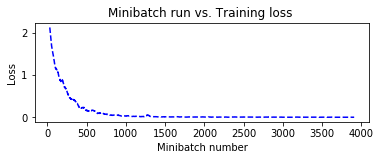

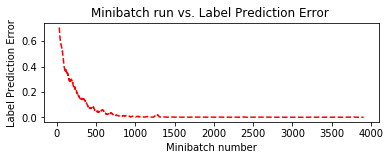

In [65]:
pred = train_and_evaluate(reader_train,
                          reader_test,
                          max_epochs=5,
                          model_func=create_basic_model)

In [71]:
url='C:/Users/rfernandez3/Documents/OpenHackImages/gear_imagesmod/rope/10373911x1013041_zm.jpeg'
myimg = np.array(PIL.Image.open(url), dtype=np.float32)

In [68]:
def eval(pred_op, image_data):
    label_lookup = labels_master
    image_mean = 133.0
    image_data -= image_mean
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))

    result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

    # Return top 3 results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]

    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]] * 100))

In [72]:
eval(pred, myimg)

Top 3 predictions:
	Label: rope      , confidence: 94.44%
	Label: insulated_jackets, confidence: 3.53%
	Label: gloves    , confidence: 1.94%


In [80]:
pred.save('cntkmodelbasic.dnn')